In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
#ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
from uwv.config import CBS80072NED, CBS_OPENDATA_PROCESSED_DATA_DIR, OUTPUT_DIR

2024-09-06 10:54:43.687 | INFO     | uwv.config:<module>:11 - PROJ_ROOT path is: C:\Users\c.hakker\OneDrive - VISTA college\Senior Stuff\Opleiding Data science\uwv


In [3]:
# Load the data
cbs = pd.read_parquet(CBS_OPENDATA_PROCESSED_DATA_DIR / f"{CBS80072NED}.parquet")

In [4]:
# Filter out rows where 'period_quarter_number' is 0
cbs = cbs[cbs['period_quarter_number'] != 0]

In [5]:
# Map quarters to months and create the 'date' column
cbs['month'] = cbs['period_quarter_number'].map({1: 1, 2: 4, 3: 7, 4: 10})
cbs['date'] = pd.to_datetime({'year': cbs['period_year'], 'month': cbs['month'], 'day': 1})

In [6]:
#Set this new 'date' column as the index
cbs.set_index('date', inplace=True)

In [7]:
# Display the DataFrame to verify
print(cbs.head())

            id      sbi    period  sick_leave_percentage      period_title  \
date                                                                         
1996-01-01   0  T001081  1996KW01                    5.5  1996 1e kwartaal   
1996-04-01   1  T001081  1996KW02                    4.6  1996 2e kwartaal   
1996-07-01   2  T001081  1996KW03                    4.0  1996 3e kwartaal   
1996-10-01   3  T001081  1996KW04                    4.7  1996 4e kwartaal   
1997-01-01   5  T001081  1997KW01                    4.9  1997 1e kwartaal   

           period_status  period_year period_type  period_quarter_number  \
date                                                                       
1996-01-01    Definitief         1996          KW                      1   
1996-04-01    Definitief         1996          KW                      2   
1996-07-01    Definitief         1996          KW                      3   
1996-10-01    Definitief         1996          KW                      4 

In [8]:
# Define a function to filter and resample data for a specific 'sbi_title'
def process_sbi_data(sbi_code):
    # Filter the data for the specific 'sbi_title'
    filtered_data = cbs[cbs['sbi'] == sbi_code]
    
    # Resample to ensure quarterly frequency
    filtered_data = filtered_data.resample('QS').asfreq()
    
    # Display the resampled data to verify
    print(filtered_data.head())
    
    return filtered_data

In [9]:
# Example: Process data for "A-U Alle economische activiteiten" (code: T001081)
sbi_code = 'T001081'
sbi_data = process_sbi_data(sbi_code)

            id      sbi    period  sick_leave_percentage      period_title  \
date                                                                         
1996-01-01   0  T001081  1996KW01                    5.5  1996 1e kwartaal   
1996-04-01   1  T001081  1996KW02                    4.6  1996 2e kwartaal   
1996-07-01   2  T001081  1996KW03                    4.0  1996 3e kwartaal   
1996-10-01   3  T001081  1996KW04                    4.7  1996 4e kwartaal   
1997-01-01   5  T001081  1997KW01                    4.9  1997 1e kwartaal   

           period_status  period_year period_type  period_quarter_number  \
date                                                                       
1996-01-01    Definitief         1996          KW                      1   
1996-04-01    Definitief         1996          KW                      2   
1996-07-01    Definitief         1996          KW                      3   
1996-10-01    Definitief         1996          KW                      4 

In [10]:
sbi_code = 'T001081'  # Example: A-U Alle economische activiteiten

# Filter data based on 'sbi_title'
filtered_cbs = cbs[cbs['sbi'] == sbi_code]

In [11]:
# Filter the data to include only dates from 2016 to 2023
filtered_cbs = filtered_cbs.loc['2016-01-01':'2023-12-31']

In [12]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

In [13]:
span = 4
alpha = 2/(span+1)

In [14]:
filtered_cbs['EWMA12'] = filtered_cbs['sick_leave_percentage'].ewm(alpha=alpha, adjust=False).mean()  # adjust=False specifies no adjustment based on time period

In [15]:
model = SimpleExpSmoothing(filtered_cbs['sick_leave_percentage'])

c:\Users\c.hakker\OneDrive - VISTA college\Senior Stuff\Opleiding Data science\uwv\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


In [16]:
fitted_model = model.fit(smoothing_level=alpha,optimized=False)

In [17]:
filtered_cbs['SES12'] = fitted_model.fittedvalues.shift(-1)

In [18]:
 #Double Exponential Smoothing

In [19]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [20]:
filtered_cbs['DESadd12'] = ExponentialSmoothing(filtered_cbs['sick_leave_percentage'], trend='add').fit().fittedvalues.shift(-1)

c:\Users\c.hakker\OneDrive - VISTA college\Senior Stuff\Opleiding Data science\uwv\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


In [21]:
filtered_cbs['DES_mul_12'] = ExponentialSmoothing(filtered_cbs['sick_leave_percentage'], trend='mul').fit().fittedvalues.shift(-1)

c:\Users\c.hakker\OneDrive - VISTA college\Senior Stuff\Opleiding Data science\uwv\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


<Axes: xlabel='date'>

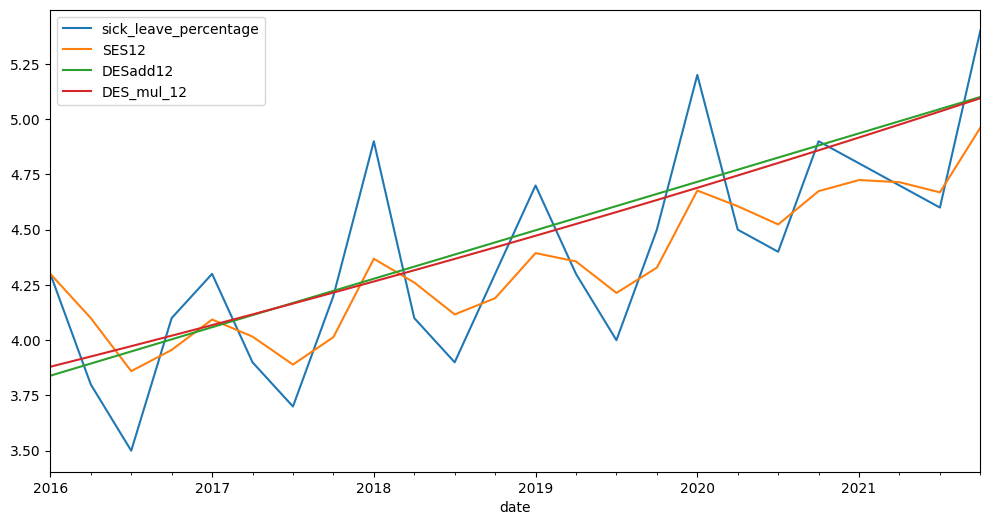

In [22]:
filtered_cbs[['sick_leave_percentage','SES12','DESadd12','DES_mul_12']].iloc[:24].plot(figsize=(12,6))

In [23]:
#Triple Exponential Smoothing 

In [24]:
filtered_cbs['TES_mul_12'] = ExponentialSmoothing(filtered_cbs['sick_leave_percentage'],trend='mul',seasonal='mul',seasonal_periods=4).fit().fittedvalues

c:\Users\c.hakker\OneDrive - VISTA college\Senior Stuff\Opleiding Data science\uwv\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


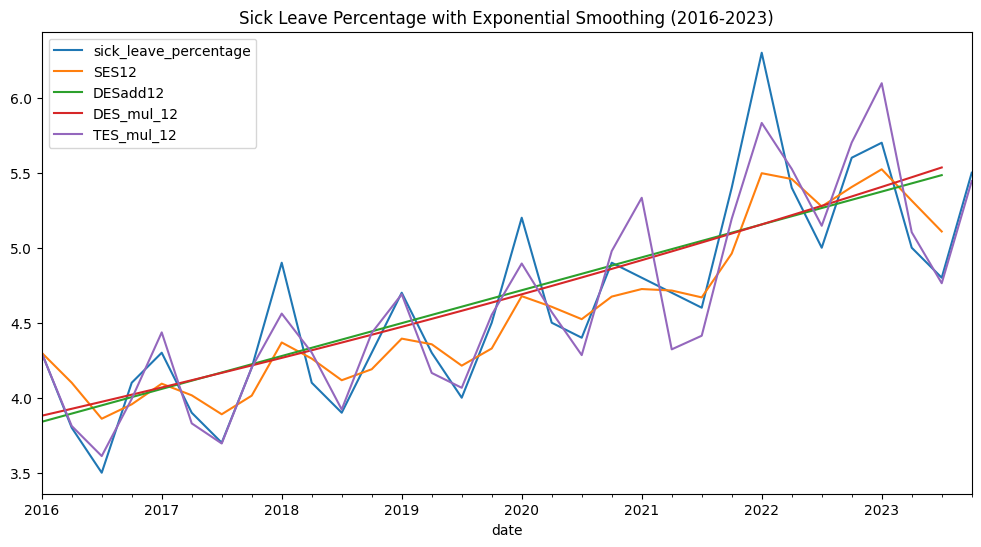

In [25]:
# Plot the results
filtered_cbs[['sick_leave_percentage', 'SES12', 'DESadd12', 'DES_mul_12','TES_mul_12']].plot(figsize=(12,6))
plt.title('Sick Leave Percentage with Exponential Smoothing (2016-2023)')
plt.show()

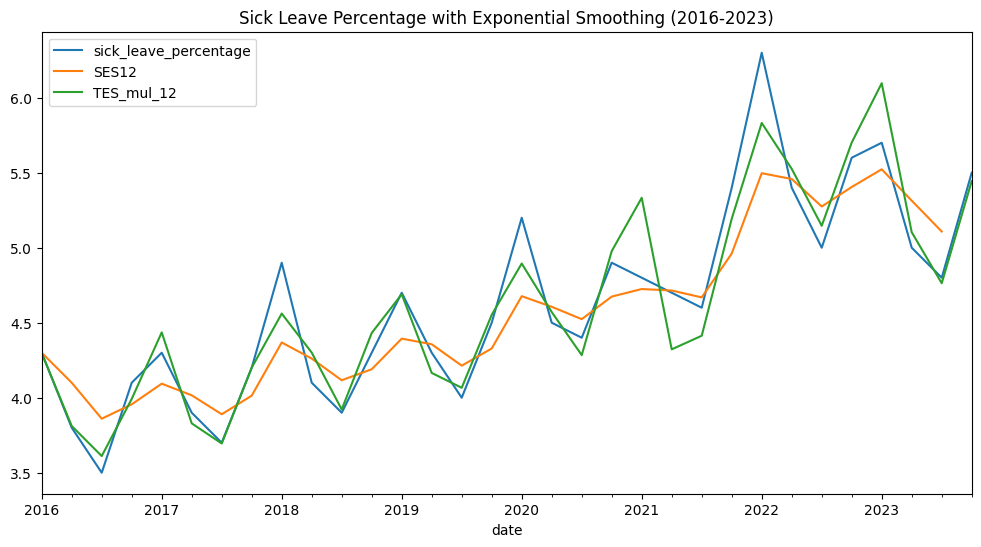

In [26]:
# Plot the results
filtered_cbs[['sick_leave_percentage', 'SES12','TES_mul_12']].plot(figsize=(12,6))
plt.title('Sick Leave Percentage with Exponential Smoothing (2016-2023)')
plt.show()